### WARNING...

To get access to `scipy.stats.bootstrap`, this notebook is in `Python3.8`, but `cirq==0.11.1` which doesn't match the standard package version for python3.8

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats

from qbitmap import simulated_annealer
from qbitmap import utils
from qbitmap import postprocess
from qbitmap import io
from scipy.stats import kendalltau
from qbitmap.metrics import bootstrap_metric
from collections import Counter


In [3]:
DATESTR = "20210620"
results_raw = np.load(f"results/hw_{DATESTR}_ghz_line_results_raw.npy")
results_corr = np.load(f"results/hw_{DATESTR}_ghz_line_results_corr.npy")
paths = np.load(f"results/hw_{DATESTR}_ghz_line_paths.npy")

# filter out bitflips that are unrealistically large (i.e. would result in ill-conditioned outcomes)
idx = np.arange(len(paths))

BF_REJECTION = 0.15
qvals = postprocess.load_qvals_arr("1624192689299", 1116, path='./readout_ec')
idx = postprocess.accept_by_bitflip(threshold=BF_REJECTION, qvals_arr=qvals)

# replace rejected states with null values so that the annealer knows to avoid them

# With the bad results nullified its not necessary to trim the paths.
# This will allow SA to still query any state for a fidelity,
# But it will "reroute" when the queried state is has fidelity `None`
results = results_corr[idx,:]
all_paths = paths[idx]


rejected 308 events for qmax>0.15


In [4]:
FLE = results[:,0].flatten()
F0 = results[:,2].flatten()
F = results[:,1].flatten()

print("FLE:", scipy.stats.kendalltau(FLE, F))
print("F0", scipy.stats.kendalltau(F0, F))

FLE: KendalltauResult(correlation=0.5462046204620462, pvalue=1.8490371713272653e-119)
F0 KendalltauResult(correlation=0.12484817254959696, pvalue=1.0856465760449625e-07)


In [5]:
parr = np.linspace(75, 95, 21)

x1 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(FLE, F, percentile) for percentile in parr])
x1_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, FLE, F, percentile, ntrials=200))
        for percentile in parr
])


x3 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(F0, F, percentile) for percentile in parr])
x3_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, F0, F, percentile, ntrials=200))
        for percentile in parr
])


x4 = 1 - parr/100


In [7]:
# Analyze difference in FLE for every pair of nearby states
G = nx.Graph()
n_qubits = 4
for i, path_i in enumerate(all_paths):
    if (i % 100) == 0:
        print(i)
    F_LE, F, F0 = results[i]
    G.add_node(i, F_LE=F_LE, F=F)
    q_i =  set(tuple(map(tuple, path_i)))

    # Track the edges used, agnostic to ordering
    edges_i = [(tuple(path_i[k]), tuple(path_i[k+1])) for k in range(n_qubits - 1)]
    
    edges_i += [(t[1], t[0]) for t in edges_i]
    for j, path_j in enumerate(all_paths):
        if j <= i:
            continue
        q_j =  set(tuple(map(tuple, path_j)))
        edges_j = [(tuple(path_j[k]), tuple(path_j[k+1])) for k in range(n_qubits - 1)]
        edges_j += [(t[1], t[0]) for t in edges_j]
        
        # Number of shared qubits
        w_ij = len(q_i.intersection(q_j))
        # Number of shared edges
        ee_ij = len(set(edges_i).intersection(set(edges_j))) // 2
        
        G.add_edge(i, j, shared_edges=ee_ij, shared_nodes=w_ij)

0
100
200
300
400
500
600
700
800


In [8]:
FLE_by_weight = {} # weight=0, 1, 2, 3, 4 - 4 since i did actually run forwards and  backwards variations...
F_by_weight = {}
for (i, j, data) in G.edges(data=True):
    delta_FLE = G.nodes[i]['F_LE'] - G.nodes[j]['F_LE']   
    delta_F = G.nodes[i]['F'] - G.nodes[j]['F']
    (ns, es) = (data['shared_nodes'], data['shared_edges'])
    if not FLE_by_weight.get((ns, es)):
        FLE_by_weight[(ns, es)] = []
    if not F_by_weight.get((ns, es)):
        F_by_weight[(ns, es)] = []   
        
    FLE_by_weight[(ns, es)].append(delta_FLE)
    F_by_weight[(ns, es)].append(delta_F)

    
FLE_by_weight = {k: np.asarray(x) for (k, x) in FLE_by_weight.items()}
F_by_weight = {k: np.asarray(x) for (k, x) in F_by_weight.items()}

In [10]:
# Don't overwrite any of the analysis using a different processor...!
from qbitmap import hw
from qbitmap import calibration_data
assert hw.PROCESSOR_ID == "weber"

TIMESTAMP = 1624192689299
target_calibration = hw.PROCESSOR.get_calibration(TIMESTAMP // 1000) # UGHHHHH
print("TIMESTAMP:", TIMESTAMP)

# Target specifically these metrics
metric_1q = "single_qubit_rb_average_error_per_gate"
metric_2q = "two_qubit_sqrt_iswap_gate_xeb_average_error_per_cycle"
calibration = calibration_data.CalibrationWrapper(
    calibration_dct=target_calibration, 
    qubits=hw.DEVICE.qubits, 
    metric_1q=metric_1q, 
    metric_2q=metric_2q
)
noise_graph = calibration.noise_graph


PROJECT ID: fermilab-quantum
PROCESSOR:  >>> weber <<<
GATESET:    <cirq_google.serializable_gate_set.SerializableGateSet object at 0x7f28654890d0>
TIMESTAMP: 1624192689299


In [11]:
len(hw.DEVICE.qubits)

53

In [12]:
def T_exp(T0, alpha, steps):
    t = np.arange(steps)
    return T0 * alpha ** t

def T_log(T0, alpha, steps):
    t = np.arange(steps)
    return T0 / (1 + alpha * np.log(1 + t))

def T_lin(T0, steps):
    t = np.linspace(0, 1, steps)
    return T0 * (1 - t)

def T_poly(T0, alpha, p, steps):
    t = np.arange(steps)
    return T0 / (1 + alpha * t ** p)

# Use pre-optimized SA params
anneal_steps = 300
T0 = 0.07
demo_temp = T_exp(T0, 0.987, anneal_steps)

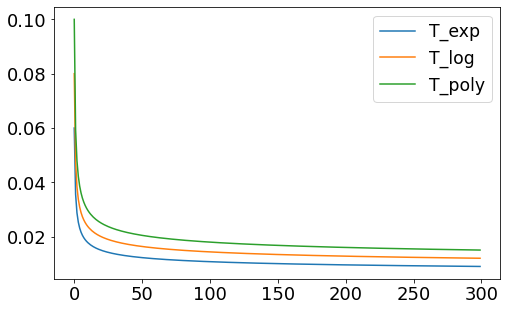

In [13]:
T0 = 0.1
# alpha = 0.98
p = 1
anneal_steps = 300

# temps1 = T_exp(T0, 0.987, anneal_steps)
# temps2 = T_log(T0, 1, anneal_steps)
# temps3 = T_poly(T0, .02, p, anneal_steps)

temps1 = T_log(0.06, 0.987, anneal_steps)
temps2 = T_log(0.08, 0.987, anneal_steps)
temps3 = T_log(0.10, 0.987, anneal_steps)


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(anneal_steps), temps1, label="T_exp")
ax.plot(range(anneal_steps), temps2, label="T_log")
ax.plot(range(anneal_steps), temps3, label="T_poly")
ax.legend(loc="upper right")

In [14]:
metric_results = results

trials = 20
TRANSITION_PROBS = [0.2, 0.8] # First element is probability of reversing in place; second element is prob(trying new qubits)
num_new_max_lst = [1, 2] # FIXME: not configured for 3 new max
temps_lst = [temps1, temps2, temps3]

all_results = [ [ None for _ in range(len(temps_lst))] for _ in range(len(num_new_max_lst))]
all_state_counts = np.zeros((3, 3, trials))

for i, num_new_max in enumerate(num_new_max_lst):
    print("num_new_max= ", num_new_max)
    for j, temp in enumerate(temps_lst):
        print("temps= ", j)
        ann_results = []
        for ell in range(trials):
            idx_state = np.random.choice(len(all_paths))
            initial_state = all_paths[idx_state]
            annealer = simulated_annealer.SimplePathFixedResultsAnnealer(
                initial_state=initial_state,
                paths=all_paths,
                fidelities=metric_results[:,0],
                graph=noise_graph,
                num_new_max=num_new_max,
                transition_probs=TRANSITION_PROBS,
                verbose=False
            )
            res, history = annealer.anneal(nsteps=anneal_steps, temperatures=temp)
            ann_results.append(history)
            all_state_counts[i,j,ell] = history['unique_states_counter'][-1]

        results_arr = np.zeros((trials, anneal_steps + 1))
        for k, res in enumerate(ann_results):
            results_arr[k,:] = res['score_history']
        all_results[i][j] = results_arr

num_new_max=  1
temps=  0
temps=  1
Stuck in a corner!
temps=  2
num_new_max=  2
temps=  0
Stuck in a corner!
temps=  1
temps=  2


Note that we cannot reject on bitflip performance and still retain a complete state space.Our solution is to just have the SA retry updating if it draws a rejected state to attempt.

### SIMULATIONS COMPLETE. DO NOT RUN.


In [16]:
ntrials = 2500
# Use pre-optimized SA params
anneal_steps = 300
T0 = 0.07
demo_temp = T_exp(T0, 0.987, anneal_steps)

# Run the SA over many trials and average the performance
anneal_outcomes = np.zeros((ntrials, anneal_steps +1))
anneal_unq_states = np.zeros(ntrials)


In [17]:
NUM_NEW_MAX = 2
TRANSITION_PROBS = [0.2, 0.8] # First element is probability of reversing in place; second element is prob(trying new qubits)



for i in range(ntrials):
    if not (i % 50):
        print(i)
    # Initialize an annealer with a randomly selected start point.
    initial_state = np.asarray(all_paths[np.random.choice(len(all_paths))])
    annealer = simulated_annealer.SimplePathFixedResultsAnnealer(
        initial_state=initial_state,
        paths=all_paths,
        fidelities=metric_results[:,0],
        graph=noise_graph,
        num_new_max=NUM_NEW_MAX,
        transition_probs=TRANSITION_PROBS,
        verbose=False
    )
    res, history = annealer.anneal(nsteps=anneal_steps, temperatures=demo_temp)

    anneal_unq_states[i] = history['unique_states_counter'][-1]
    anneal_outcomes[i,:] = history['score_history']

0
Stuck in a corner!
Stuck in a corner!
50
Stuck in a corner!
Stuck in a corner!
100
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
150
Stuck in a corner!
Stuck in a corner!
200
Stuck in a corner!
250
300
Stuck in a corner!
350
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
400
450
Stuck in a corner!
Stuck in a corner!
500
Stuck in a corner!
550
600
Stuck in a corner!
Stuck in a corner!
650
Stuck in a corner!
700
Stuck in a corner!
750
800
Stuck in a corner!
850
900
Stuck in a corner!
950
Stuck in a corner!
1000
Stuck in a corner!
1050
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
1100
Stuck in a corner!
Stuck in a corner!
1150
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
1200
Stuck in a corner!
Stuck in a corner!
1250
1300
1350
Stuck in a corner!
Stuck in a corner!
1400
1450
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
Stuck in a corner!
1500
Stuck in a co

### MC comparison to randomized schemes

The samples of $n_i$ should be made only once with respect to number of unique state queries.

In [18]:
ntrials_rand = 10000

In [19]:
state_counts = np.unique(anneal_unq_states)

# 1000 attempts per count of unq states
found = np.zeros((len(state_counts), ntrials_rand))
print(found.shape)
for i, n_attempt in enumerate(state_counts):
    for j in range(ntrials_rand):
        idx = np.random.choice(len(all_paths), size=int(n_attempt), replace=False)
        found[i,j] = max(FLE[idx])
        

(45, 10000)


Note that statistics on each n_i are normal-ish centered around $\langle n_i \rangle$. This means that eacn $n_i$ will have a sampling error that grows with $| n_i - \langle n_i \rangle|$ which will distort the uncertainty we associate with each $F_{max}(n_i)$ where $F_{max}$ is the best score found by an annealer. For instance, assuming variance is the statistic we're interested in, defining $\text{Var}(F) = \sigma^2$ we have some associated variance 

$$
S = \text{Var}({\sigma^2})
$$

which apparently goes something like $\mu_4 / n$ where $\mu_4$ is the 4-th moment of the distribution over $F$ induced by $p(n)$. 

In [20]:
np.save("results/anneal_unq_states.npy", anneal_unq_states)
np.save("results/anneal_outcomes.npy", anneal_outcomes)
np.save("results/random_results.npy", found)


In [21]:
anneal_unq_states = np.load("results/anneal_unq_states.npy")
anneal_outcomes = np.load("results/anneal_outcomes.npy")
found = np.load("results/random_results.npy")

In [24]:
x0 = np.mean(baseline_perf)
x1 = np.mean(annealer_perf)
print("ANNEALER IMPROVEMENT FACTOR")
print(x1 / x0)

ANNEALER IMPROVEMENT FACTOR
1.0290302264316975


### Make figure 5

In [26]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """This will truncate a colormap that assumes a [0, 1] range.

    After truncation, the color that formerly corresponded to `0` will correspond
    to `minval`, while the color that formerly corresponded to `1` will be
    represented by `maxval`.
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


PROJECT ID: fermilab-quantum
PROCESSOR:  >>> rainbow <<<
GATESET:    <cirq_google.serializable_gate_set.SerializableGateSet object at 0x7f28654890d0>
0.8589942168000863
[0.881341]
0.878059201187387
[3.80936076]
0.8994986801122667
[7.10205782]


/tmp/ipykernel_12524/3648642828.py:126: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(right=0.85)


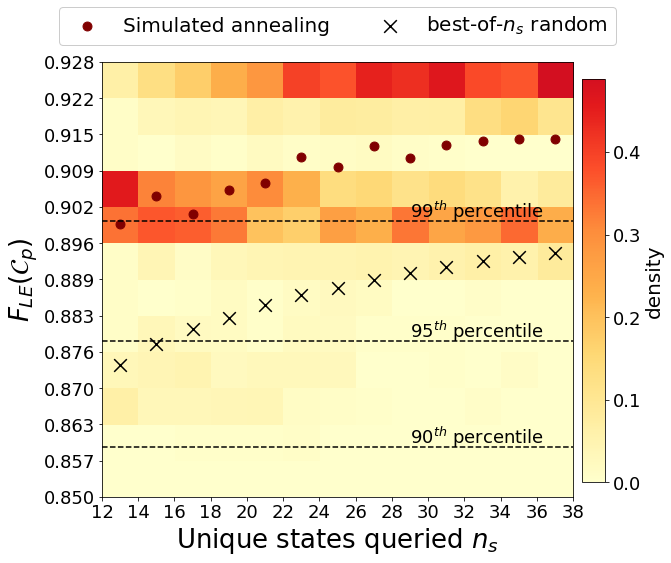

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharey=True, constrained_layout = True)

axes = [ax]

anneal_best = np.max(anneal_outcomes, axis=1)
state_counts = np.unique(anneal_unq_states)

# Define hexbin grid extent
xmin = min(anneal_unq_states)
xmax = max(anneal_unq_states)
ymin = min(*anneal_best, *found.flatten())
ymax = max(*anneal_best, *found.flatten())

keeprange_x = [12, 38]
keeprange_y = [0.85, ymax]
ext = (keeprange_x[0], keeprange_x[1], keeprange_y[0], keeprange_y[1])
xbins = (ext[1] - ext[0] + 1) // 2

rand_counts_arr = np.tile(state_counts, ntrials_rand)


H_anneal, xedges, yedges = np.histogram2d(anneal_unq_states, 
                                   anneal_best, 
                                   range=[keeprange_x, keeprange_y], 
                                   bins=[xbins, 12])
H_anneal = H_anneal / H_anneal.sum(axis=1, keepdims=True)


base_cmap = 'YlOrRd'
cmap = truncate_colormap(plt.get_cmap(base_cmap), 0, 0.8)

im = axes[0].imshow(H_anneal.T, origin='lower', cmap=cmap)



# rand_counts_arr = np.tile(state_counts, ntrials_rand)
# H_rand, xedges_rand, yedges_rand = np.histogram2d(rand_counts_arr, 
#                                    found.flatten(order='F'), 
#                                    range=[keeprange_x, keeprange_y], 
#                                    bins=[xbins, 12])
# H_rand = H_rand / H_rand.sum(axis=1, keepdims=True)
# axes[1].imshow(H_rand.T, origin='lower', cmap='cividis')


xstride = 1
for ax in axes:
    # left-edge ticks (looks ugly.)
    x_idx_keep = np.arange(0, len(xedges), xstride)
    xticks = x_idx_keep - 0.5
    ax.set_xticks(xticks)
    ax.set_xticklabels(xedges.astype(int)[x_idx_keep])

    

    # Centered ticks (looks ugly?)
#     centered_ticks = xedges + 1
#     x_idx_keep = np.arange(1, len(xedges) - 1, xstride)
#     ax.set_xticks(x_idx_keep )
#     ax.set_xticklabels(centered_ticks.astype(int)[x_idx_keep])

ystride = 1
y_idx_keep = np.arange(0, len(yedges), ystride)
axes[0].set_yticks(y_idx_keep - 0.5)
yticklabels_fmt = np.asarray([f"{x:2.3f}" for x in yedges])[y_idx_keep]
axes[0].set_yticklabels(yticklabels_fmt)


# Overlay avg performance; need to generate statistics

# For each xtick value, we will interpolate an x position
# at which to overlay the average y-values, in imshow coords.
# These are in arbitrary coordinates, e.g. [0, 1, 2, 3, ...] and
# are an interpolation of arbitrary coordinates [-0.5, 0.5, 1.5, ...]
# which are in one-to-xstride correspondence with left cell edges
# (given as xedges[:-1])
xticks_interpolated = xticks[:-1] + np.diff(xticks)/2
xedges_interpolated = xedges[:-1] + np.diff(xedges)/2

# This isn't clean but should work: Grab the desired yvalues
# using xedges_interpolated as keys, but then do the 
# actual plotting with respect to xticks_interpolated
yvals = np.zeros(len(xedges_interpolated))
yvals_rand = np.zeros(len(xedges_interpolated))
for i, cts in enumerate(xedges_interpolated):
    slc = np.where(anneal_unq_states == cts)
    yvals[i] = np.average(anneal_best[slc])
    trial_num = np.where(state_counts == cts)
    yvals_rand[i] = np.average(found[trial_num,:])
# Last step is to transform yvals into the ytick coordinate
# system in a similar way. Now we don't do discrete interpolation,
# but instead try to transform an almost-continuous representation
# of the ytick coordinate system.
yticks = axes[0].get_yticks()
yticks_interpolated = yticks[:-1] + np.diff(yticks)/2
yedges_interpolated = yedges[:-1] + np.diff(yedges)/2
yticklabs = yedges[y_idx_keep]

def xform_yval_to_ytick_coords(yarr):
    ytick_delta = max(yticks_interpolated) - min(yticks_interpolated)
    yedge_delta = max(yedges_interpolated) - min(yedges_interpolated)
    return (yarr - min(yedges_interpolated)) * ytick_delta / yedge_delta + min(yticks_interpolated)

markersize = 80
axes[0].scatter(xticks_interpolated, xform_yval_to_ytick_coords(yvals), c='maroon', marker='o', s=markersize, label="Simulated annealing")
axes[0].scatter(xticks_interpolated, xform_yval_to_ytick_coords(yvals_rand), c='black', marker='x', s=2*markersize, label=r"best-of-$n_s$ random")
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), framealpha=1, ncol=2, prop={'size': 20} )

for ax in axes:
    ax.set_xlabel(r"Unique states queried $n_s$", size=26)
axes[0].set_ylabel(r"$F_{LE}(\mathcal{C}_p)$", size=26)

# axes[0].text(-0.05, 1.08, r"a", horizontalalignment='center', verticalalignment='center', size=24, transform=axes[0].transAxes, weight="bold")

# percentile overlays
for k in [90, 95, 99]:
    perc = np.percentile(FLE, k)
    print(perc)
    zzz = xform_yval_to_ytick_coords([perc])
    print(zzz)
    percentile_color = 'k'
    axes[0].axhline(zzz[0], c=percentile_color, ls='--')
    axes[0].text(8, zzz[0] + 0.1, f"{k}" + r"$^{th}$ percentile", size=18, c=percentile_color)

    
# colorbar  
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.7, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, )
cbar_ax.set_ylabel("density", size=20)

# DRAFT
import os
DRAFT = False
if DRAFT:
    axes[0].text(-.2,1.2, "/annealer_ghz_line_n4_scratchwork.ipynb", color='red', horizontalalignment='left', verticalalignment='center', size=12, transform=axes[0].transAxes, weight="bold")
fig.savefig("../../figures/figure5.pdf",bbox_inches='tight')

